In [1]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from parseData import readHeroes
import torch
import torch.nn as nn
import torchvision 
import torchvision.transforms as transforms

/usr/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [3]:
def plotHeroUsage(Y,N):
    heroes = Y['hero_picked'].unique()
    counts = []
    for hero in heroes:
        counts.append(len(Y[Y['hero_picked'] == hero]))
    counts = np.array(counts)
    heroes = heroes[counts.argsort()[-N:]]
    counts = counts[counts.argsort()[-N:]]
    print(counts[-1]/len(Y))
    y_pos = np.arange(len(heroes))
    plt.bar(y_pos,counts, align='center', alpha=0.5)
    plt.xticks(y_pos,heroes)
    plt.ylabel('counts')
    plt.title('Hero usage')
    plt.show()

In [4]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [5]:
def toHeroID(Y):
    hero_ids = []
    for y in Y:
        if np.argwhere(y==1).size <= 0:
            hero_ids.append(0)
        else:
            hero_ids.append(np.argwhere(y==1)[0][0] +1)
    return np.array(hero_ids) 

In [6]:
data = pd.read_csv('224051329_22_all_X.csv')
Y = pd.read_csv('224051329_22_all_Y.csv')
skip_ban = False
if ('banned_hero1'not in data.columns):
    skip_ban = True
heroes =  readHeroes()
num_heroes = int(list(heroes.keys())[-1])
data =  data.dropna(1,'all')

0.2262686567164179


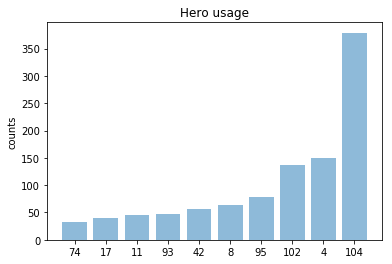

In [24]:
plotHeroUsage(Y,10)

In [8]:
X = data.drop(columns=['match_id','version','start_time'])
X = X.fillna(0)
allies = np.zeros((X.shape[0],num_heroes))
enemies = np.zeros((X.shape[0],num_heroes))
if not skip_ban:
    banned = np.zeros((X.shape[0],num_heroes))
output = np.zeros((Y.shape[0],num_heroes))
for i,row in X.iterrows():
    allies[i,int(row['ally_hero1'])-1] = 1
    allies[i,int(row['ally_hero2'])-1] = 1
    allies[i,int(row['ally_hero3'])-1] = 1
    allies[i,int(row['ally_hero4'])-1] = 1
    enemies[i,int(row['enemy_team1'])-1] = 1
    enemies[i,int(row['enemy_team2'])-1] = 1
    enemies[i,int(row['enemy_team3'])-1] = 1
    enemies[i,int(row['enemy_team4'])-1] = 1
    enemies[i,int(row['enemy_team5'])-1] = 1
    if not skip_ban:
        if 'banned_hero1' in row:
            banned[i,int(row['banned_hero1'])-1] = 1
        if 'banned_hero2' in row:
            banned[i,int(row['banned_hero2'])-1] = 1
        if 'banned_hero3' in row:
            banned[i,int(row['banned_hero3'])-1] = 1
        if 'banned_hero4' in row:
            banned[i,int(row['banned_hero4'])-1] = 1
        if 'banned_hero5' in row:
            banned[i,int(row['banned_hero5'])-1] = 1
        if 'banned_hero6' in row:
            banned[i,int(row['banned_hero6'])-1] = 1
        if 'banned_hero7' in row:
            banned[i,int(row['banned_hero7'])-1] = 1
        if 'banned_hero8' in row:
            banned[i,int(row['banned_hero8'])-1] = 1
        if 'banned_hero9' in row:
            banned[i,int(row['banned_hero9'])-1] = 1
        if 'banned_hero10' in row:
            banned[i,int(row['banned_hero10'])-1] = 1
        if 'banned_hero11' in row:
            banned[i,int(row['banned_hero11'])-1] = 1
        if 'banned_hero12' in row:
            banned[i,int(row['banned_hero12'])-1] = 1
    hero_picked = Y['hero_picked'][i]
    hero_picked = Y['hero_picked'][i]
    output[i,hero_picked-1] = 1

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,Y)

In [21]:
clf = RandomForestClassifier(n_estimators=100)
rf = clf.fit(X_train,y_train)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [22]:
prediction = rf.predict(X_test)
ground_truth = np.array(y_test).flatten()
np.sum(prediction == ground_truth) / len(ground_truth)

0.20763723150357996

In [12]:
clf = svm.SVC(decision_function_shape='ovo')
svm_model = clf.fit(X_train,y_train)

/usr/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [13]:
prediction = svm_model.predict(X_test)
ground_truth = np.array(y_test).flatten()
np.sum(prediction == ground_truth) / len(ground_truth)

0.24105011933174225

In [14]:
if not skip_ban:
    X = np.concatenate((allies,enemies,banned),1)
else:
    X = np.concatenate((allies,enemies),1)
    
Y = output
X_train, X_test, y_train, y_test = train_test_split(X,Y)

In [ ]:
input_size = X_train.shape[1]
actual_ids = toHeroID(y_train)-1
actual_ids = actual_ids
output_size = y_train.shape[1]
# output_size = 
hidden_size = 5
num_epochs = 100000
batch_size = 100
learning_rate = 0.001
# log_model = nn.Linear(input_size,output_size)
# might need a sigmoid ^
nn_model = NeuralNet(input_size,hidden_size,output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr = learning_rate)
for epoch in range(num_epochs):
    # Convert numpy arrays to torch tensors
    inputs = torch.from_numpy(np.array(X_train,dtype=np.float32))
    targets = torch.from_numpy(np.array(actual_ids,dtype=np.int64))

    # Forward pass
    outputs = nn_model(inputs)
    loss = criterion(outputs.squeeze(), targets)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))



Epoch [5/100000], Loss: 4.8782
Epoch [10/100000], Loss: 4.8590
Epoch [15/100000], Loss: 4.8406
Epoch [20/100000], Loss: 4.8215
Epoch [25/100000], Loss: 4.8015
Epoch [30/100000], Loss: 4.7802
Epoch [35/100000], Loss: 4.7575
Epoch [40/100000], Loss: 4.7333
Epoch [45/100000], Loss: 4.7076
Epoch [50/100000], Loss: 4.6804
Epoch [55/100000], Loss: 4.6516
Epoch [60/100000], Loss: 4.6210
Epoch [65/100000], Loss: 4.5888
Epoch [70/100000], Loss: 4.5549
Epoch [75/100000], Loss: 4.5192
Epoch [80/100000], Loss: 4.4818
Epoch [85/100000], Loss: 4.4428
Epoch [90/100000], Loss: 4.4022
Epoch [95/100000], Loss: 4.3601
Epoch [100/100000], Loss: 4.3166
Epoch [105/100000], Loss: 4.2717
Epoch [110/100000], Loss: 4.2255
Epoch [115/100000], Loss: 4.1781
Epoch [120/100000], Loss: 4.1294
Epoch [125/100000], Loss: 4.0794
Epoch [130/100000], Loss: 4.0282
Epoch [135/100000], Loss: 3.9753
Epoch [140/100000], Loss: 3.9210
Epoch [145/100000], Loss: 3.8653
Epoch [150/100000], Loss: 3.8083
Epoch [155/100000], Loss: 3.75

In [ ]:
prediction = nn_model(torch.from_numpy(np.array(X_test,dtype=np.float32))).detach().numpy()

In [ ]:
labels = np.argmax(y_test,axis=1)+1
sum((np.argmax(prediction,axis=1)+1) == labels )/ len(labels)

In [ ]:
clf = RandomForestClassifier(n_estimators=100)
rf = clf.fit(X_train,y_train)

In [ ]:
prediction = rf.predict(X_test)
sum((np.argmax(prediction,axis=1)+1) == labels )/ len(labels)